In [1]:
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="Set2")
import scipy
import json

from scipy import sparse

import time
import gc

from sklearn.manifold import TSNE

In [2]:
data_dir = '2022-06-02'
colors = ['darkgrey','crimson','lightcoral','saddlebrown',
          'orange','lawngreen',
          'teal','skyblue','royalblue','navy',
          'deeppink','c']

In [3]:
len(colors)

12

In [3]:
papers = pd.read_csv(f'scibert_encoded_papers/valid_metadata_{data_dir}.csv',sep='\t').set_index('cord_uid')[['title','journal','publish_time']].sort_values('publish_time')

In [4]:
jrnls = Counter(papers['journal']).most_common()

In [6]:
# pd.DataFrame(jrnls,columns=['JRNL','CNT']).to_excel('jrnls_cnt.xlsx')

In [5]:
# selected = ['Int J Environ Res Public Health','Front Public Health','Br J Surg','Front Immunol','Int J Mol Sci','J Clin Med']
# selected = ['Int J Environ Res Public Health','Br J Surg','Int J Mol Sci']
selected = ['Br J Surg','MMWR Morb Mortal Wkly Rep','Rev Med Virol','Front Immunol',
            'Int J Mol Sci','Emerg Infect Dis','J Med Internet Res',
            'Front Cell Dev Biol','JAMA Netw Open','Curr Psychol','Foods','Nat Commun']
# selected = ['']
# selected = [jrnl for jrnl, cnt in jrnls[:10]]

In [6]:
n_per_class = 50

In [7]:
samples = []
for jrnl in selected:
    df = papers.loc[papers['journal']==jrnl]
    if df.shape[0] > n_per_class:
        df = df.sample(n=n_per_class, random_state=0)
    samples.append(df)
samples = pd.concat(samples,axis=0)

In [8]:
samples['label'] = list(map(lambda x:selected.index(x),samples['journal'].tolist()))

In [9]:
models_embeddings = dict()

for method in ['tfidf','glove','scibert','biobert']:#
    # method = 'scibert'
    # method = 'tfidf'
    # SCIBERT Embedding
    if method == 'scibert':
        print('scibert')
        title_embs_df = pd.read_csv(f'scibert_encoded_papers/title_embs_df_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'scibert_encoded_papers/abstract_embs_df_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
    if method == 'biobert':
        print('biobert')
        title_embs_df = pd.read_csv(f'title_embs_df_biobert_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_biobert_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # Glove Embedding
    if method == 'glove':
        print('glove')
        title_embs_df = pd.read_csv(f'title_embs_df_glove_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_glove_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]


    # TF-IDF Embedding
    if method == 'tfidf':
        print('tfidf')
        values = scipy.sparse.load_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz')
        index = json.load(open(f"tf-idf-results/index_{data_dir}_scibert_token",'r',encoding='utf-8'))
        column = json.load(open(f"tf-idf-results/column_{data_dir}_scibert_token",'r',encoding='utf-8'))
        # paper_emb = pd.DataFrame.sparse.from_spmatrix(values,columns=column,index=index)
        uid_map = {uid:i for i,uid in enumerate(index)}
        X = values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
    
    models_embeddings[method] = X

tfidf
glove
scibert
biobert


In [10]:
not_show = []

d:\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, 

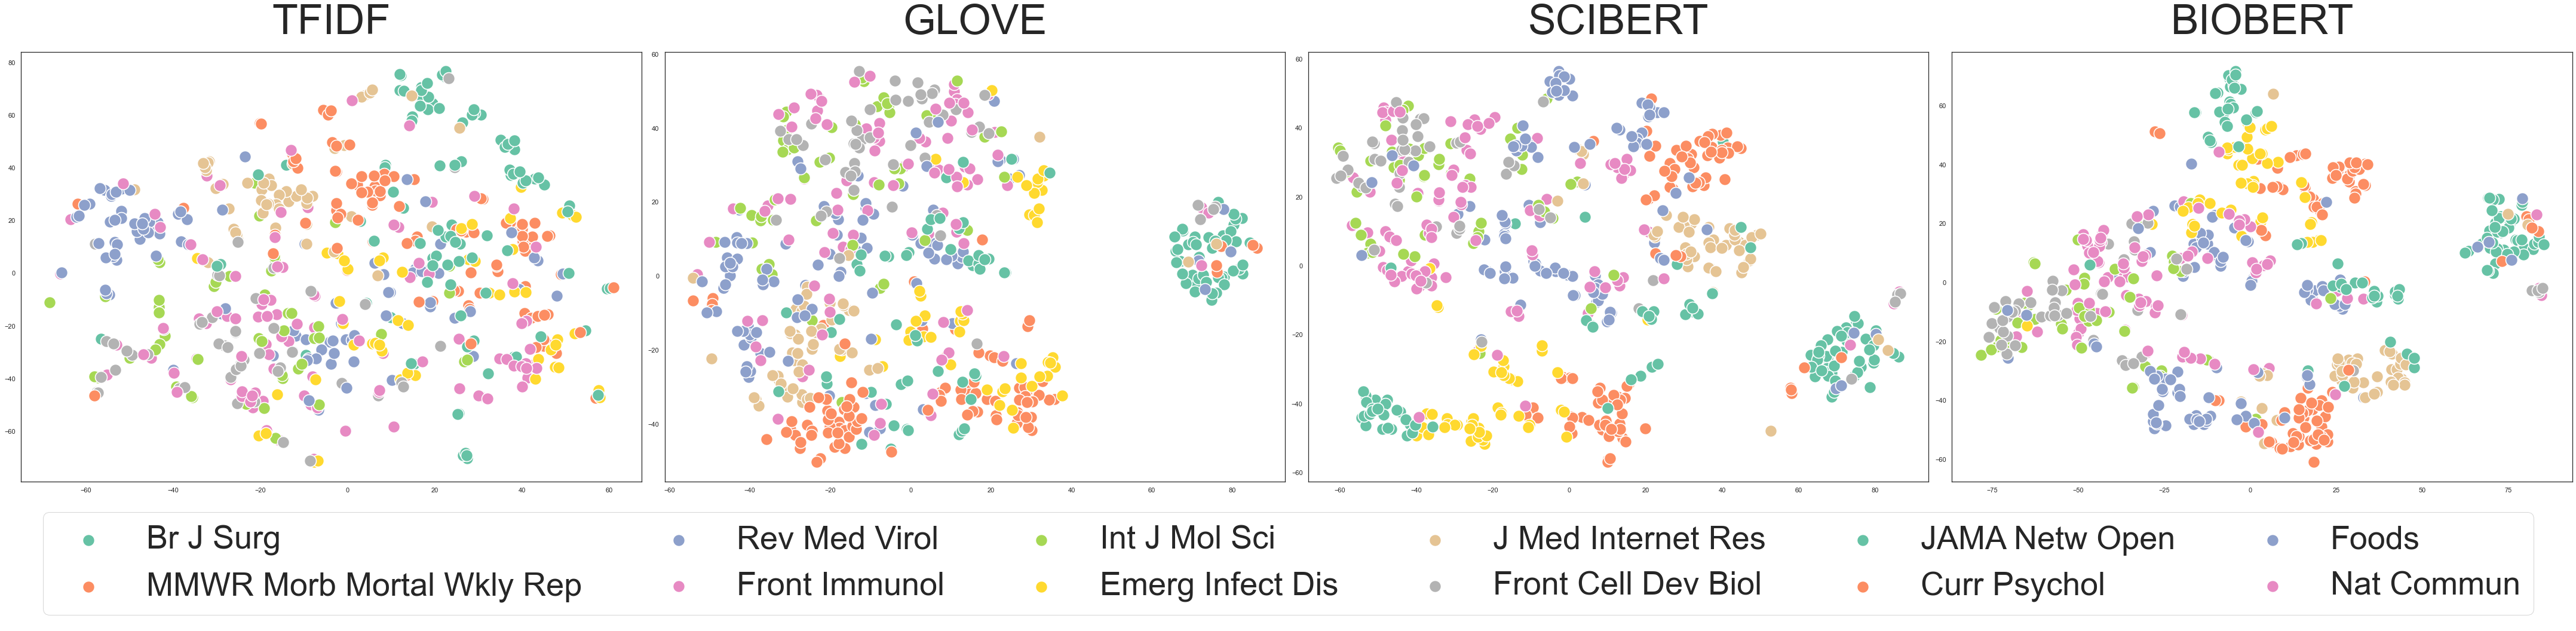

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(60,15))

for idx, (method_name, x) in enumerate(models_embeddings.items()):

    X_tsne = TSNE(n_components=2, perplexity=5,learning_rate=200, metric='cosine',n_jobs=-1, random_state = 0).fit_transform(x) 

    # plt.figure(figsize=(15,15))
    for i in range(len(selected)):
        if i not in not_show:
            cords = X_tsne[samples['label'] == i]
            x,y = cords[:,0],cords[:,1]
            sns.scatterplot(x,y,marker='o', ax=axes[idx], label=selected[i], s=400, alpha=1.0, legend=False) # , c=colors[i], label=selected[i]
    #         plt.scatter(x,y,marker='o', label=selected[i])

    axes[idx].set_title(method_name.upper(), fontsize=70, pad=30)
#     ax = axes[idx]
#     axes[idx].legend(fontsize=12, loc='best')
#     plt.legend()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(selected)//2, fontsize=54)
    
fig.tight_layout()
fig.subplots_adjust(bottom=0.25)

#fig.savefig(f"paper_jrnls/paper_jrnls.jpg", dpi=500)

In [ ]:
# cluster metric的指标：
# 补充 聚类指标：不同embed下 已知labeled 类别，算指标。

# https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [13]:
from sklearn import metrics

In [16]:
models_embeddings['tfidf']

<600x21642 sparse matrix of type '<class 'numpy.float64'>'
	with 69861 stored elements in Compressed Sparse Row format>

In [14]:

for i in ['tfidf','glove','scibert','biobert']:
    # calinski_harabasz_score 越高越好
    if i == 'tfidf':
        print(i+' + calinski_harabasz_score:',metrics.calinski_harabasz_score(models_embeddings[i].toarray() , samples['label']))
    # davies_bouldin_score 越小越好
        print(i+' + davies_bouldin_score:',metrics.davies_bouldin_score(models_embeddings[i].toarray() , samples['label']))

    #轮廓系数取值为[-1, 1]，其值越大越好，且当值为负时，表明 ai<bi，样本被分配到错误的簇中，聚类结果不可接受。对于接近0的结果，则表明聚类结果有重叠的情况。

        print(i+' + silhouette_score:',metrics.silhouette_score(models_embeddings[i].toarray() , samples['label']))
    #silhouette_samples 

    else:
        print(i+' + calinski_harabasz_score:',metrics.calinski_harabasz_score(models_embeddings[i], samples['label']))
        # davies_bouldin_score 越小越好
        print(i+' + davies_bouldin_score:',metrics.davies_bouldin_score(models_embeddings[i], samples['label']))

        #轮廓系数取值为[-1, 1]，其值越大越好，且当值为负时，表明 ai<bi，样本被分配到错误的簇中，聚类结果不可接受。对于接近0的结果，则表明聚类结果有重叠的情况。

        print(i+' + silhouette_score:',metrics.silhouette_score(models_embeddings[i], samples['label']))
        #silhouette_samples 


tfidf + calinski_harabasz_score: 2.5143918237989693
tfidf + davies_bouldin_score: 7.554721180142772
tfidf + silhouette_score: 0.0030561035588559157
glove + calinski_harabasz_score: 22.206745413846622
glove + davies_bouldin_score: 4.752940341020922
glove + silhouette_score: 0.013625215242429854
scibert + calinski_harabasz_score: 20.347318197931028
scibert + davies_bouldin_score: 4.41141993672148
scibert + silhouette_score: 0.033060277359009065
biobert + calinski_harabasz_score: 28.940207318937784
biobert + davies_bouldin_score: 4.302197044445232
biobert + silhouette_score: 0.022242358134536615


In [20]:
models_embeddings['scibert'].shape

(600, 1536)